In [ ]:
%load_ext autoreload 
%autoreload 2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import surp
import surp.gce_math as gcem
import arya
import vice

/users/PAS2232/aeyobd/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [2]:
calc_y = np.vectorize(gcem.calc_y)

In [3]:
def load_model(name):
    """
    Finds the pickled model with either the given name or the parameters 
    and returns the csv summary
    """
    
    file_name = "../models/" + name + "/stars.csv"
    model =  pd.read_csv(file_name, index_col=0)
    yield_params = surp.YieldParams.from_file("../models/" + name + "/yield_params.json")
    surp.set_yields(yield_params, verbose=False)
    return model

In [4]:
from singlezone import run_singlezone

In [5]:
def psinglezone_data(x="MG_H", y="C_MG", **kwargs):
    data_kwargs = dict(
        color="k", 
        stat="median",
    )
    kwargs = dict(numbins=20, **kwargs)

    
    df = surp.plots.filter_high_alpha(surp.subgiants)
    arya.medianplot(df, x=x, y=y, zorder=-2, **data_kwargs, **kwargs)

In [7]:
import astropy.units as u

In [8]:
surp.set_yields()

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.28e-03 + 3.00e-02 (Z - Z0)   1.00 × cristallo11             0                              

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       





In [9]:

#vice.yields.ccsne.settings["c"] = 1e-3
#vice.yields.agb.settings["c"] = surp.yield_models.ZeroAGB()

In [10]:
sz, h = run_singlezone(dt=0.003)

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

In [11]:
ele = "c"

y_c = vice.yields.ccsne.settings[ele]
if isinstance(y_c, float):
    y_cc = lambda x: y_c
else:
    y_cc = y_c
Mc = h[f"mass({ele})"].values * u.Msun
time = h.time.values * u.Gyr
time = time.to("yr")

r =h["r_eff"]
eta = h["eta_0"]
r = 0.4
denom =  (1 + eta - r).values
sfr = h.sfr.values * u.Msun / u.year
Zc = h[f"z({ele})"].values

dM_dep = -sfr * Zc * denom 
y_cc_t = [y_cc(z) for z in h["z"]]
dM_cc = sfr * y_cc_t
dM_c = np.gradient(Mc, time)


dM_agb = dM_c - dM_cc - dM_dep

f_agb = dM_agb / (dM_agb + dM_cc)


In [12]:
dt = np.gradient(time)
M_agb = np.sum(dM_agb * dt)
M_cc = np.sum(dM_cc * dt)

In [13]:
f_tot = M_agb / (M_agb + M_cc)

/users/PAS2232/aeyobd/.local/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


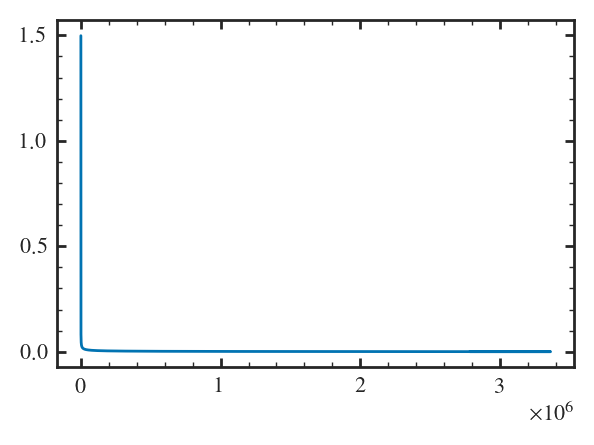

In [14]:
plt.plot(Mc, (np.cumsum(dM_c * np.gradient(time)) - Mc) / Mc)

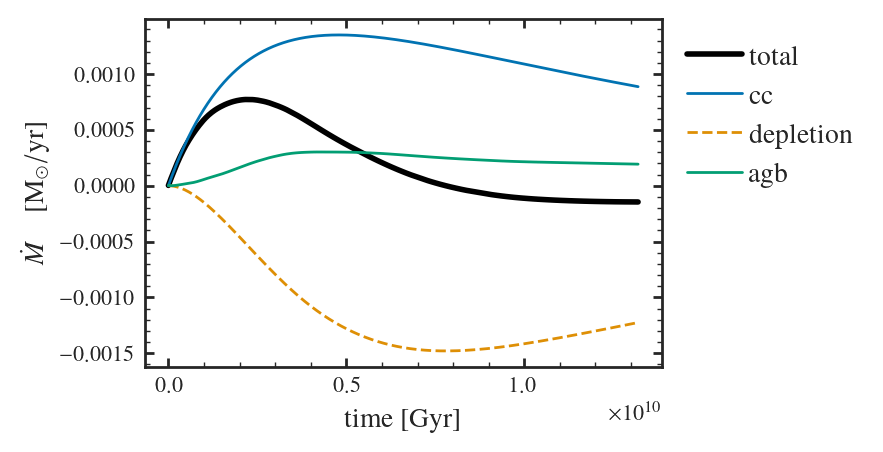

In [15]:
plt.plot(time, dM_c, "k-", lw=2, label="total")
plt.plot(time, dM_cc, label="cc")
plt.plot(time, dM_dep, "--", label="depletion")
plt.plot(time, dM_agb, label="agb")
plt.xlabel("time [Gyr]")
plt.ylabel(r"$\dot{M}\quad [\rm M_\odot / yr]$")
arya.Legend(-1)

0.20344861831806338


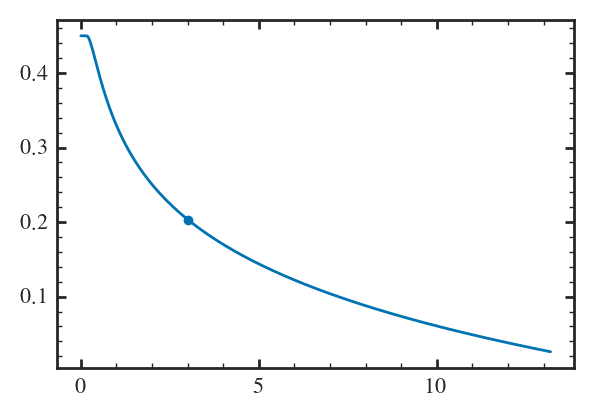

In [29]:
tau_late = 3*u.Gyr
a_fe = -h["[fe/o]"]
plt.plot(time/1e9, a_fe)
idx = np.where(time > tau_late)[0][0]

fe_half = a_fe[idx]
plt.scatter(time[idx]/1e9, fe_half)
print(fe_half)

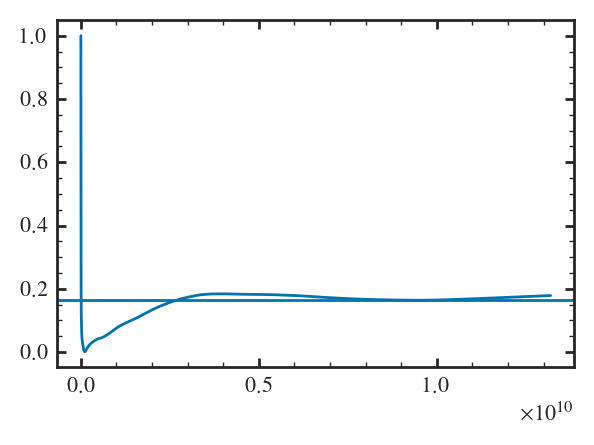

In [30]:
plt.plot(time, f_agb)
plt.axhline(f_tot)

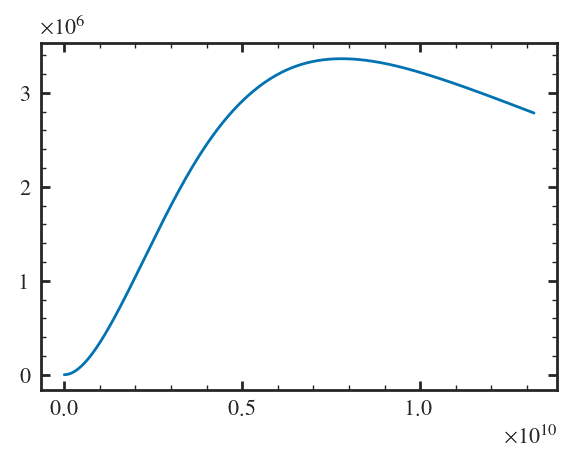

In [31]:
plt.plot(time, Mc)

In [32]:
h = fiducial.history
m_star = h["sfr"]*1e9 # Msun/yr (default)
denom = 1 + h["eta_0"] - h["r_eff"]
Mc = h["mass(c)"] # Msun

Zc = Mc / h["mgas"]
dt = h.time.unique()[1] # Gyr

smooth = 10
Mc_dot = np.concatenate([np.zeros(smooth), 
                         Mc[smooth:] - np.array(Mc[:-smooth]),
                        ]
                       )/(smooth*dt)
Z = h["z"]

y_cc = vice.yields.ccsne.settings["c"]
yc_cc = y_cc(Z)
y_c = (Mc_dot + denom*Zc*m_star)/m_star
y_c_agb = y_c - yc_cc
f_agb = np.array(y_c_agb/y_c)

X = np.reshape(f_agb, (200, -1))

NameError: name 'fiducial' is not defined

# Actual comparisons

In [61]:
def plot_model(model, x="MG_H_true", y="C_MG_true", **kwargs,):
    model_kwargs = dict(
        stat="median", errorbar=None,
        aes="line", numbins=20
    )
    df = surp.plots.filter_high_alpha(model)
    
    filt = ~model.high_alpha
    plt.scatter(model[x][filt], model[y][filt], label="model", s=1)
    filt = model.high_alpha
    plt.scatter(model[x][filt], model[y][filt], label="model", s=1)
    
    arya.medianplot(df, x=x, y=y, label="model", **model_kwargs, **kwargs)

    
def plot_model_caafe(model, x="MG_FE_true", y="C_MG_true", **kwargs,):
    plt.scatter(model[x], model[y], label="model", s=1, c=model["MG_H"])
    
    df = surp.plots.filter_metallicity(model)
    data_kwargs = dict(
        color="k", 
        stat="median",
    )
    arya.medianplot(df, x=x, y=y, zorder=-2, **data_kwargs)

In [99]:
eq_correction = 10**-0.02

def plot_eq_caah(**kwargs):
    M_H = np.linspace(-0.45, 0.45, 1000)
    Zs = gcem.MH_to_Z(M_H)
    ys = calc_y(Zs)
    ymg = calc_y(Zs, "mg")

    co = gcem.abund_to_brak(ys / ymg*eq_correction, "C", "MG")
    oh = gcem.abund_to_brak(ymg, "C", "MG")
    
    plt.plot(M_H, co, label="equilibrium", color="k", lw=2, **kwargs)
    
    
def plot_eq_caafe(**kwargs):
    M_H = np.linspace(-0.45, 0.45, 1000)
    Zs = gcem.MH_to_Z(M_H)
    yc = calc_y(Zs)
    ymg = calc_y(Zs, "mg")
    yfe = calc_y(Zs, "fe")

    co = gcem.abund_to_brak(yc / ymg * 10**-0.05, "C", "MG")
    ofe = gcem.abund_to_brak(ymg/yfe, "mg", "fe")
    
    plt.plot(ofe, co, label="equilibrium", **kwargs)
    
def sz_caafe(eta=0.5, tau_sfh=15, tau_star=2.5,  **kwargs):
    sz, h = run_singlezone(eta=eta, tau_sfh=tau_sfh, tau_star=tau_star)
    plt.plot(h.O_FE, h.C_O, color=arya.COLORS[0], lw=2, **kwargs)
    return sz

In [88]:
def compare_caah(model):
    #plot_data()
    plot_model(model)
    plot_eq_caah()
    
    plt.xlim(-1.5, 0.5)
    plt.ylim(-0.6, 0.1)
    plt.xlabel("[Mg/H]")
    plt.ylabel("[C/Mg]")

In [101]:
def compare_caafe(model, **kwargs):
    plot_model_caafe(model)
    plot_eq_caafe(**kwargs)
    sz_caafe(label="singlezone")
    sz_caafe(label="singlezone",tau_star=2, tau_sfh=7.5, eta=0)

    plt.xlabel("[Mg/Fe]")
    plt.ylabel("[C/Mg]")

In [95]:
def compare(name):
    model = load_model(name)
    fig, axs = plt.subplots(1, 2, figsize=(8, 3), )
    #fig.title(name)
    plt.sca(axs[0])
    compare_caah(model)
    
    plt.sca(axs[1])
    compare_caafe(model)
    

In [96]:
model = load_model("C11_oob")

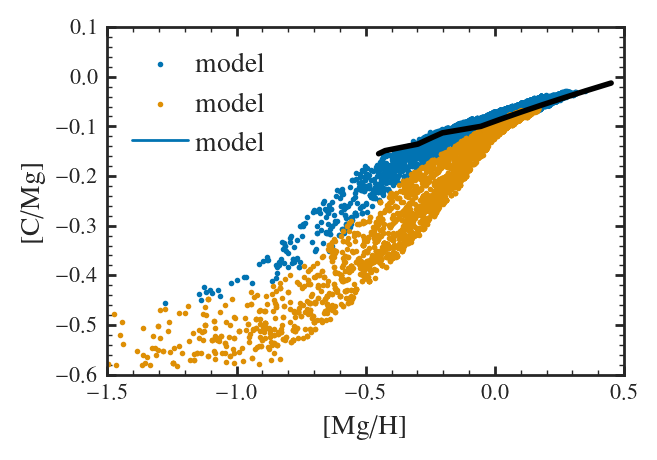

In [97]:
compare_caah(model)

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

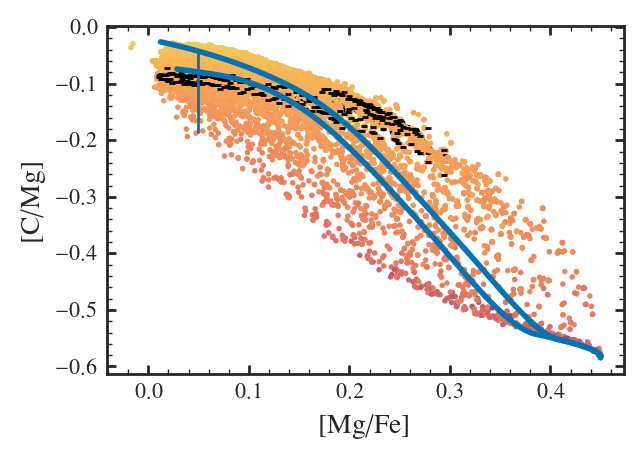

In [102]:
compare_caafe(model)

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

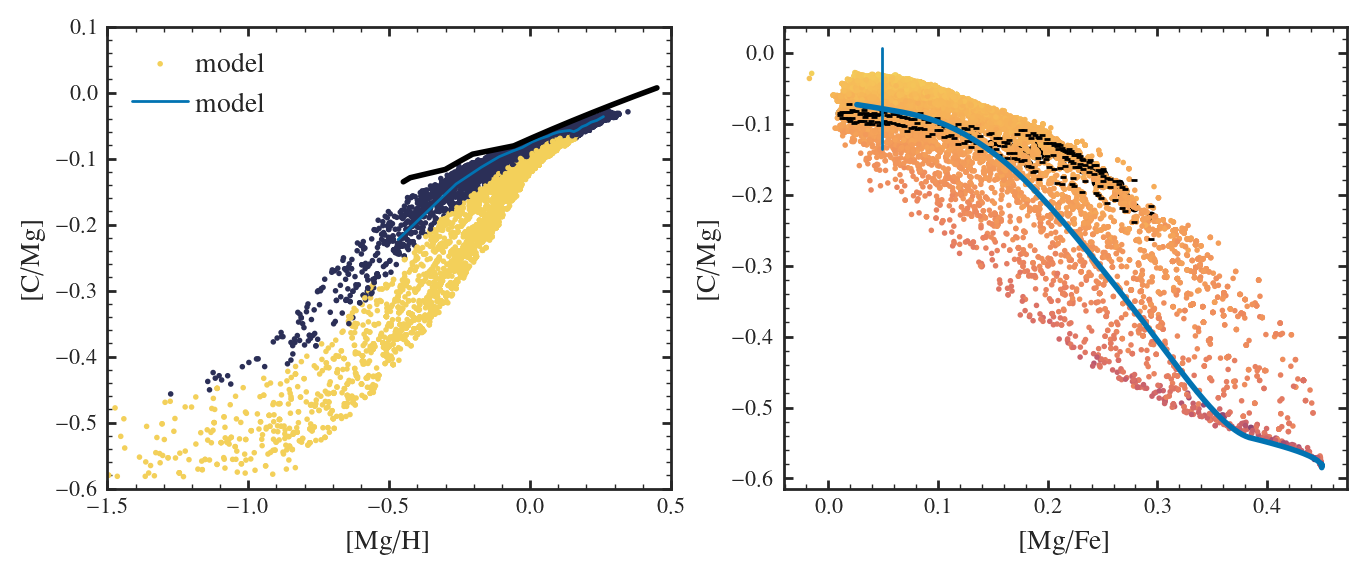

In [37]:
compare("C11_oob")

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

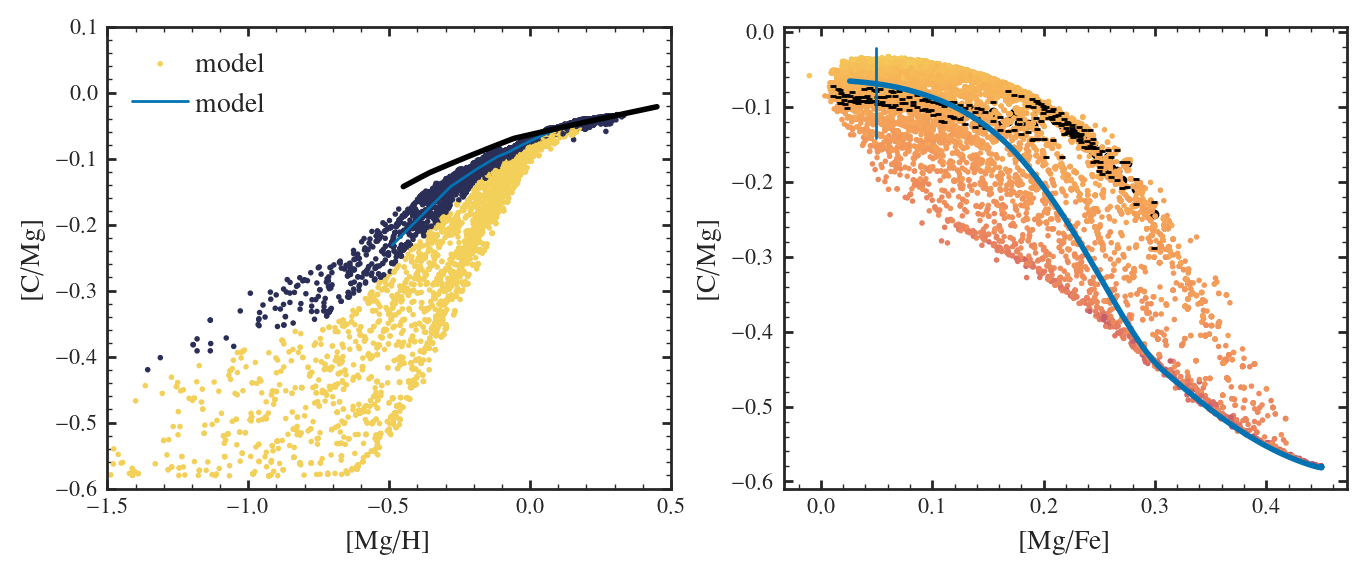

In [38]:
compare("K16_oob")

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

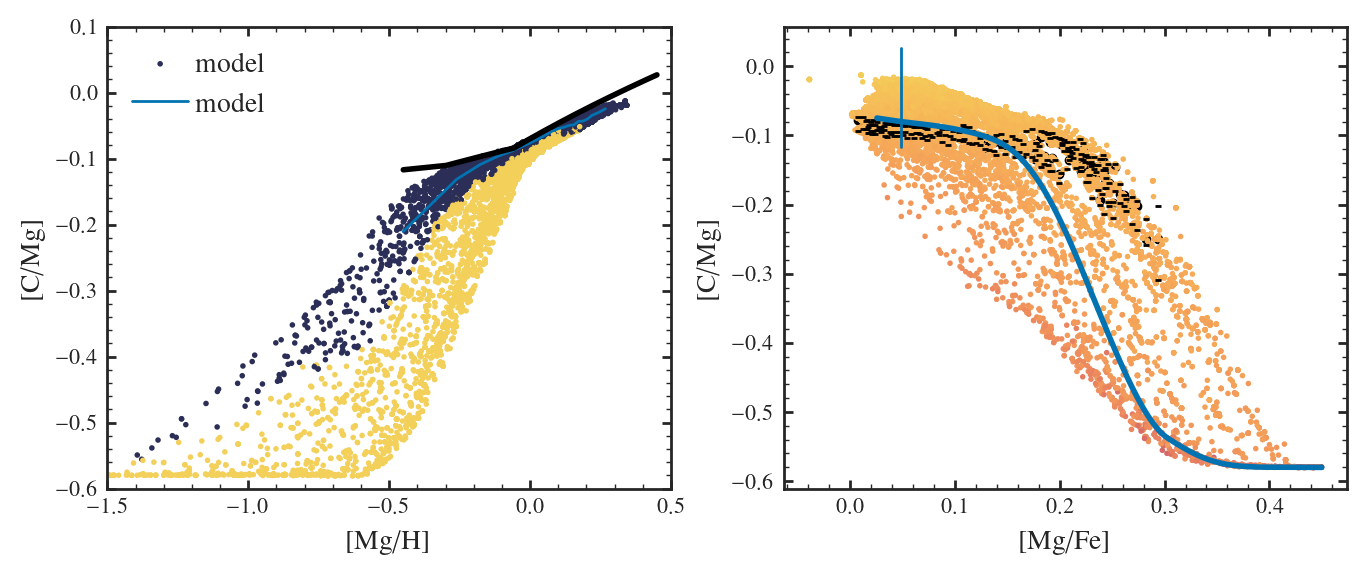

In [39]:
compare("V13_oob")

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

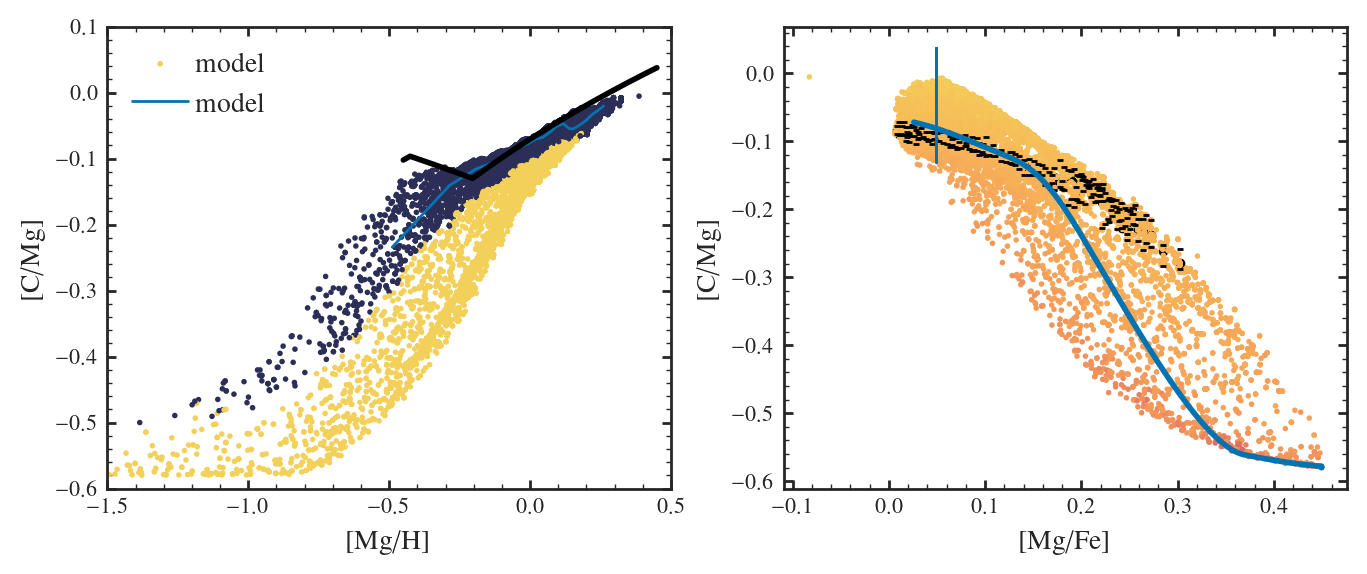

In [40]:
compare("P16_oob")

/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

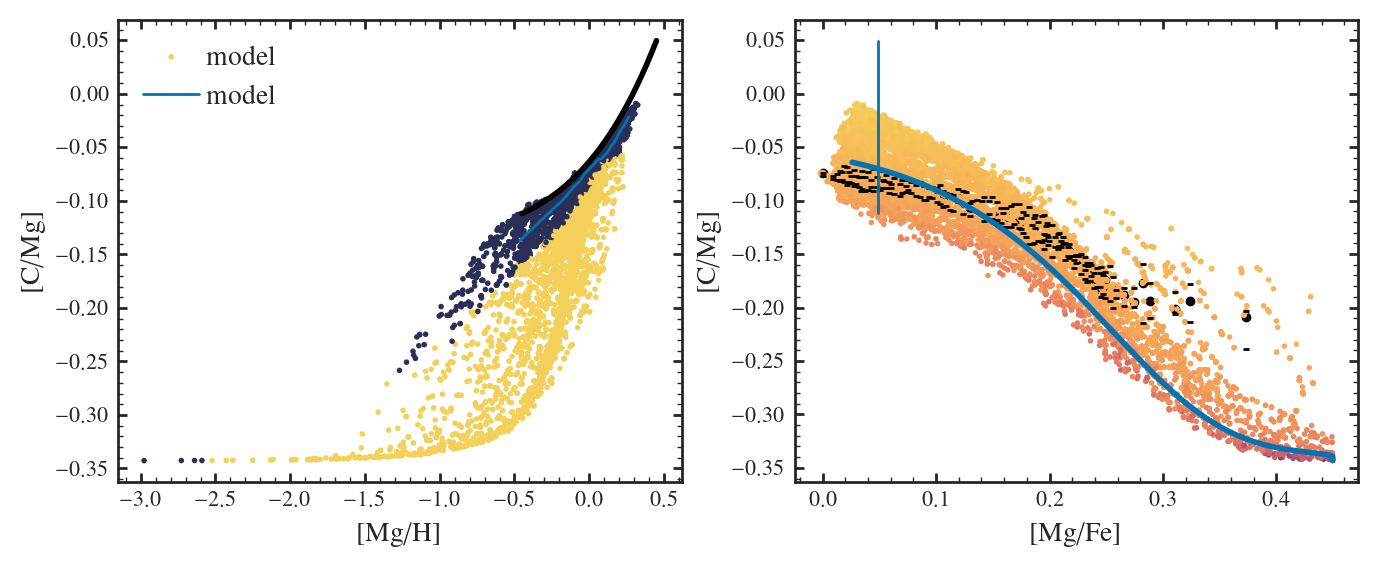

In [87]:
compare("A_f0.2_zeta_agb-0.02_t_d0.3_tau_agb0.3")

In [39]:
def plot_ssp_mgh(Z, **kwargs):
    m_c, times = vice.single_stellar_population("c", Z=Z, mstar=1)
    m_mg, times = vice.single_stellar_population("mg", Z=Z, mstar=1)

    c_mg = gcem.abund_to_brak(np.array(m_c)/m_mg, "C", "MG")
    fe_mg = gcem.abund_to_brak(np.array(m_mg), "Fe", "MG")
    plt.plot(mg_h, c_mg, **kwargs)


In [40]:
def plot_ssp_femg(Z, **kwargs):
    m_c, times = vice.single_stellar_population("c", Z=Z, mstar=1)
    m_mg, times = vice.single_stellar_population("mg", Z=Z, mstar=1)
    m_fe, times = vice.single_stellar_population("fe", Z=Z, mstar=1)

    c_mg = gcem.abund_to_brak(np.array(m_c)/m_mg, "C", "MG")
    mg_fe = gcem.abund_to_brak(np.array(m_mg)/m_fe, "MG", "FE")
    plt.plot(mg_fe, c_mg, **kwargs)


In [41]:
fiducial = surp.ViceModel.from_saved("../models/C11_f0.2/model.json")

Text(0.5, 1.0, 'Binned APOGEE trends')

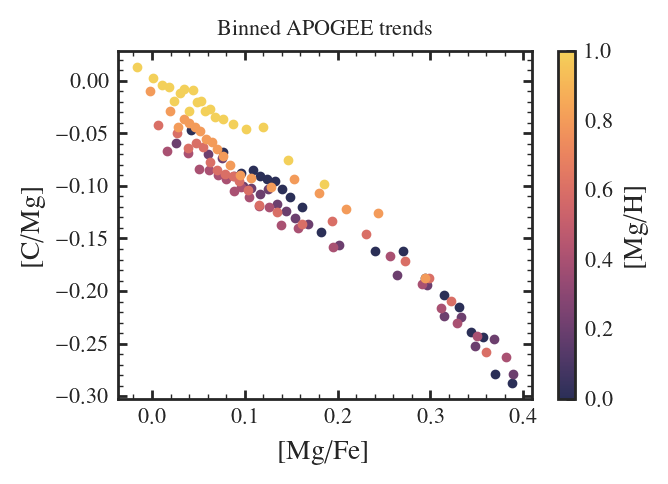

In [42]:
hm = arya.figure.colorbar.HueMap((-0.3, 0.3))

for c in np.linspace(-0.3, 0.3, 6):
    df = surp.plots.filter_metallicity(surp.subgiants,w=0.05,c=c)
    arya.medianplot(df, "MG_FE", "C_MG", numbins=20, color=hm(c), errorbar=None)

plt.colorbar(label="[Mg/H]")
plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")
plt.title("Binned APOGEE trends")

In [74]:
def compare_ssp_caafe(name):
    model = load_model(name)

    MH=-0.1
    df = surp.plots.filter_metallicity(model, c=MH)
    plt.scatter(df.MG_FE_true, df.C_MG_true, s=0.1, alpha=1, vmin=-0.5)
    for dMH in [ -0.15, -0.1, -0.05, 0, 0.05]:
        plot_ssp_femg(Z=gcem.MH_to_Z(MH - dMH), color=arya.COLORS[1], lw=1)

    plt.xlabel("[Mg/Fe]")
    plt.ylabel("[C/Mg]")

/tmp/slurmtmp.27851406/ipykernel_95946/2307334858.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(df.MG_FE_true, df.C_MG_true, s=0.1, alpha=1, vmin=-0.5)
/tmp/slurmtmp.27851406/ipykernel_95946/1533341937.py:6: RuntimeWarning: invalid value encountered in divide
  c_mg = gcem.abund_to_brak(np.array(m_c)/m_mg, "C", "MG")
/tmp/slurmtmp.27851406/ipykernel_95946/1533341937.py:7: RuntimeWarning: invalid value encountered in divide
  mg_fe = gcem.abund_to_brak(np.array(m_mg)/m_fe, "MG", "FE")


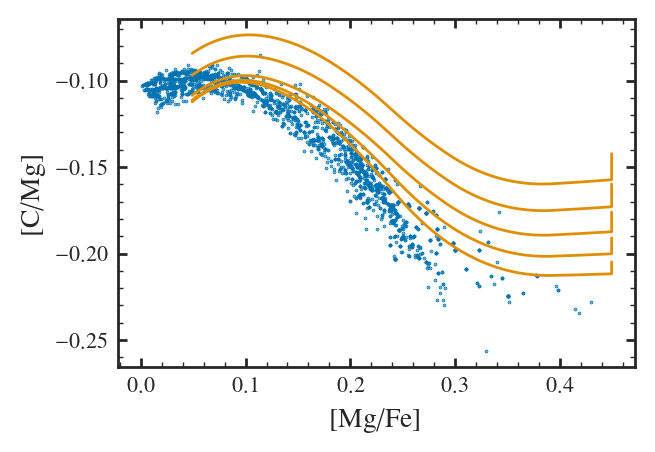

In [75]:
compare_ssp_caafe("C11_f0.2")

/tmp/slurmtmp.27851406/ipykernel_95946/2307334858.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(df.MG_FE_true, df.C_MG_true, s=0.1, alpha=1, vmin=-0.5)
/tmp/slurmtmp.27851406/ipykernel_95946/1533341937.py:6: RuntimeWarning: invalid value encountered in divide
  c_mg = gcem.abund_to_brak(np.array(m_c)/m_mg, "C", "MG")
/tmp/slurmtmp.27851406/ipykernel_95946/1533341937.py:7: RuntimeWarning: invalid value encountered in divide
  mg_fe = gcem.abund_to_brak(np.array(m_mg)/m_fe, "MG", "FE")


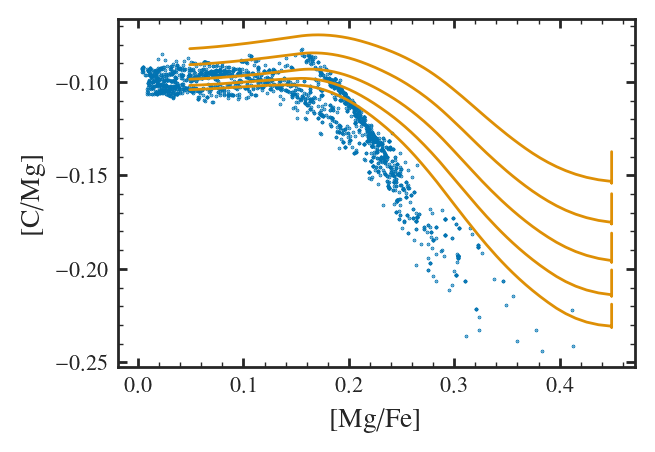

In [76]:
compare_ssp_caafe("K16_f0.2")

/tmp/slurmtmp.27851406/ipykernel_95946/2307334858.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(df.MG_FE_true, df.C_MG_true, s=0.1, alpha=1, vmin=-0.5)
/tmp/slurmtmp.27851406/ipykernel_95946/1533341937.py:6: RuntimeWarning: invalid value encountered in divide
  c_mg = gcem.abund_to_brak(np.array(m_c)/m_mg, "C", "MG")
/tmp/slurmtmp.27851406/ipykernel_95946/1533341937.py:7: RuntimeWarning: invalid value encountered in divide
  mg_fe = gcem.abund_to_brak(np.array(m_mg)/m_fe, "MG", "FE")


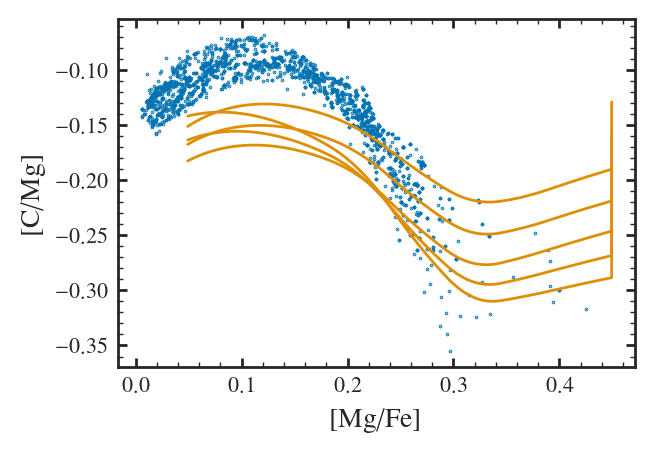

In [77]:
compare_ssp_caafe("V13_f0.2")

/tmp/slurmtmp.27851406/ipykernel_95946/2307334858.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(df.MG_FE_true, df.C_MG_true, s=0.1, alpha=1, vmin=-0.5)
/tmp/slurmtmp.27851406/ipykernel_95946/1533341937.py:6: RuntimeWarning: invalid value encountered in divide
  c_mg = gcem.abund_to_brak(np.array(m_c)/m_mg, "C", "MG")
/tmp/slurmtmp.27851406/ipykernel_95946/1533341937.py:7: RuntimeWarning: invalid value encountered in divide
  mg_fe = gcem.abund_to_brak(np.array(m_mg)/m_fe, "MG", "FE")


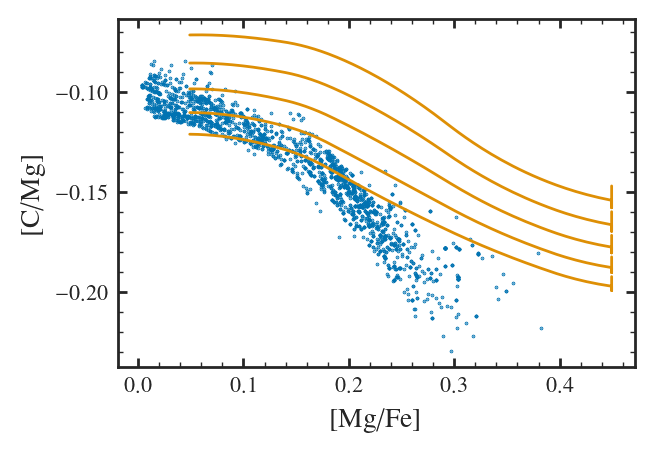

In [78]:
compare_ssp_caafe("P16_f0.2")

/tmp/slurmtmp.27851406/ipykernel_95946/2307334858.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(df.MG_FE_true, df.C_MG_true, s=0.1, alpha=1, vmin=-0.5)
/tmp/slurmtmp.27851406/ipykernel_95946/1533341937.py:6: RuntimeWarning: invalid value encountered in divide
  c_mg = gcem.abund_to_brak(np.array(m_c)/m_mg, "C", "MG")
/tmp/slurmtmp.27851406/ipykernel_95946/1533341937.py:7: RuntimeWarning: invalid value encountered in divide
  mg_fe = gcem.abund_to_brak(np.array(m_mg)/m_fe, "MG", "FE")


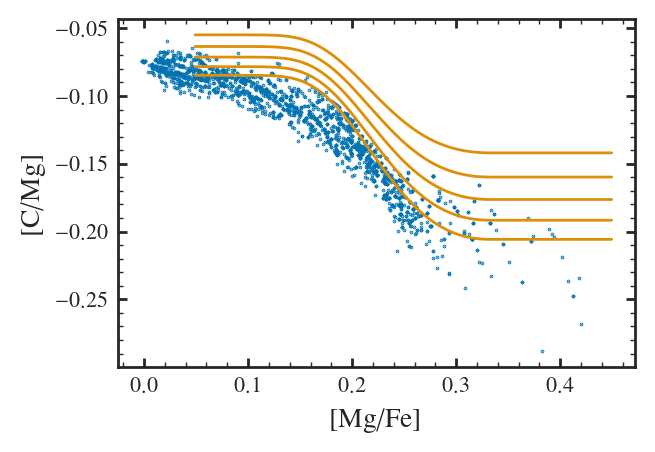

In [80]:
compare_ssp_caafe("A_f0.2_zeta_agb-0.02_t_d0.3_tau_agb0.3")

/tmp/slurmtmp.27851406/ipykernel_95946/2307334858.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(df.MG_FE_true, df.C_MG_true, s=0.1, alpha=1, vmin=-0.5)
/tmp/slurmtmp.27851406/ipykernel_95946/1533341937.py:6: RuntimeWarning: invalid value encountered in divide
  c_mg = gcem.abund_to_brak(np.array(m_c)/m_mg, "C", "MG")
/tmp/slurmtmp.27851406/ipykernel_95946/1533341937.py:7: RuntimeWarning: invalid value encountered in divide
  mg_fe = gcem.abund_to_brak(np.array(m_mg)/m_fe, "MG", "FE")


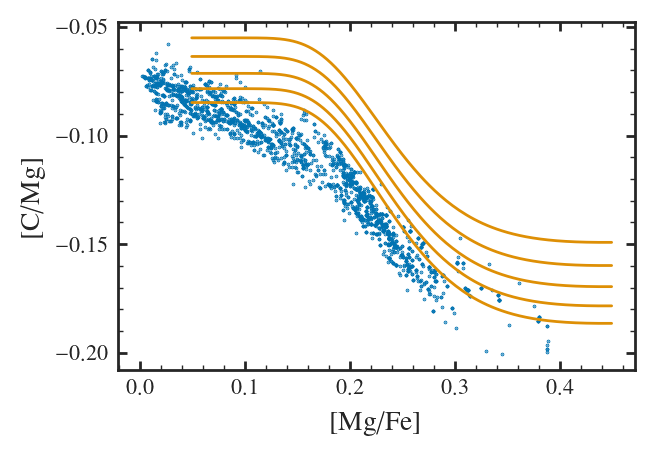

In [86]:
compare_ssp_caafe("A_f0.2_zeta_agb0.0_t_d0.15_tau_agb0.3")

## Properties of solar stars

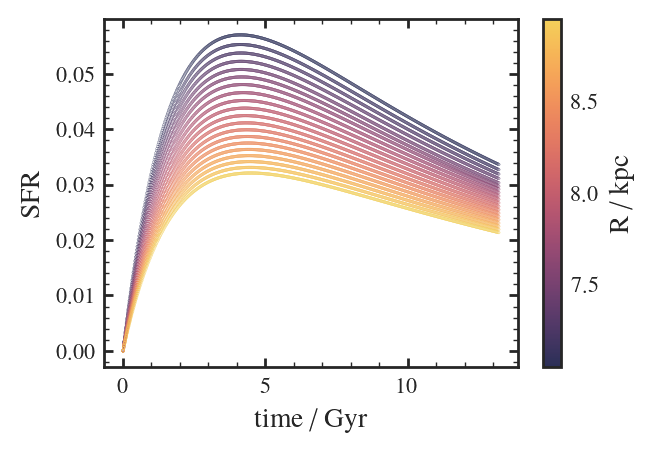

In [99]:
filt = fiducial.history.R > 7
filt &= fiducial.history.R < 9
h = fiducial.history[filt]
plt.scatter(h.time, h.sfr, s=0.01, alpha=1, c=h.R)
plt.xlabel("time / Gyr")
plt.ylabel(r"SFR")
plt.colorbar(label="R / kpc")

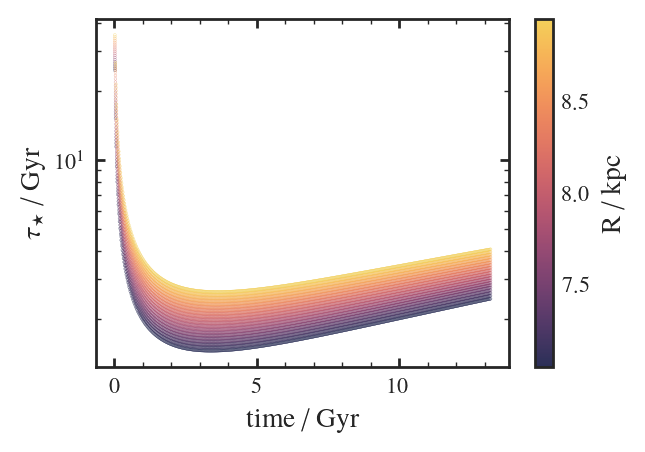

In [100]:
filt = fiducial.history.R > 7
filt &= fiducial.history.R < 9
h = fiducial.history[filt]
plt.scatter(h.time, 1/(h.sfr/ h.mgas * 1e9), s=0.01, alpha=1, c=h.R)
plt.yscale("log")
plt.xlabel("time / Gyr")
plt.ylabel(r"$\tau_\star$ / Gyr")
plt.colorbar(label="R / kpc")